In [1]:
# ===================================================================
# # 1. Setup & Imports
# This section handles package installation, folder creation, and all
# necessary library imports for the project.
# ===================================================================
import subprocess
import sys
import os
import glob

# Install required packages
print("--- Installing required packages ---")
required = [
    "torch", "torchvision", "timm", "opencv-python", "numpy", "scipy", "scikit-learn",
    "matplotlib", "Pillow", "tqdm", "scikit-image", "distinctipy"
]
for pkg in required:
    try:
        __import__(pkg.split('-')[0])
    except ImportError:
        print(f"Installing {pkg}...")
        subprocess.run([sys.executable, "-m", "pip", "install", pkg], check=True)
print("--- All packages are ready ---\n")

# Import all libraries
import torch
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from skimage.segmentation import watershed
from skimage.morphology import disk, binary_opening, binary_closing, remove_small_objects
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from torchvision import transforms
import distinctipy


--- Installing required packages ---
Installing opencv-python...
Installing scikit-learn...
Installing Pillow...
Installing scikit-image...
--- All packages are ready ---



In [2]:
# ===================================================================
# # 2. Globals & Configuration
# Central place for all important variables and settings.
# ===================================================================
# --- Device and Seed ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42) if torch.cuda.is_available() else None

# --- File Paths and Folders ---
DATASET_FOLDER = "silk_dataset"
# Create standard folders
folders = [
    "results/visualizations", "results/segmentation", "results/analysis",
    "models/checkpoints", "data/processed", "logs"
]
for folder in folders:
    os.makedirs(folder, exist_ok=True)

# --- Images for Evaluation ---
# The specific images requested for testing
# NOTE: Update extensions if they are not .jpg
TEST_IMAGE_FILENAMES = ["img_2711.jpg", "img_2849.jpg", "img_2868.jpg", "img_3009.jpg"]

print(f"Device set to: {DEVICE}")
print(f"Dataset folder: '{DATASET_FOLDER}'")
print(f"Images to be tested: {TEST_IMAGE_FILENAMES}")


Device set to: cuda
Dataset folder: 'silk_dataset'
Images to be tested: ['img_2711.jpg', 'img_2849.jpg', 'img_2868.jpg', 'img_3009.jpg']


In [3]:
# ===================================================================
# # 3. Data Loading
# Functions and classes related to dataset management.
# ===================================================================
def find_all_images(dataset_folder):
    """Finds all image paths in a given folder."""
    exts = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
    image_paths = []
    for ext in exts:
        image_paths.extend(glob.glob(os.path.join(dataset_folder, f"*{ext}")))
        image_paths.extend(glob.glob(os.path.join(dataset_folder, f"*{ext.upper()}")))
    return sorted(list(set(image_paths)))

# Find all available images (optional, for reference)
all_image_paths = find_all_images(DATASET_FOLDER)
print(f"\nFound {len(all_image_paths)} total images in the dataset folder.")


Found 1351 total images in the dataset folder.


In [4]:
# ===================================================================
# # 4. Network Architecture
# Definition of the neural network for feature extraction (DINOv2).
# ===================================================================
class DINOFeatureExtractor:
    """Wrapper for DINOv2 model to extract patch features."""
    def __init__(self, model_name='dinov2_vitb14', device='cuda'):
        self.device = device
        self.model = torch.hub.load('facebookresearch/dinov2', model_name, pretrained=True).to(device).eval()
        self.transform = transforms.Compose([
            transforms.Resize((518, 518), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.patch_size = 14
        self.spatial_dim = 518 // self.patch_size  # Should be 37

    def extract_features(self, image_path):
        """Extracts dense patch features from a single image."""
        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            print(f"Error: Image not found at {image_path}")
            return None
            
        tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            features_dict = self.model.forward_features(tensor)
            patch_features = features_dict['x_norm_patchtokens']
            
        # Reshape to (H, W, D)
        patches = patch_features.reshape(1, self.spatial_dim, self.spatial_dim, -1)
        return patches.squeeze(0).cpu().numpy()

# Instantiate the feature extractor
print("\nInitializing DINOv2 Feature Extractor...")
feature_extractor = DINOFeatureExtractor(device=DEVICE)
print("Feature Extractor is ready.")



Initializing DINOv2 Feature Extractor...


Using cache found in C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Feature Extractor is ready.


In [5]:
# ===================================================================
# # 5. Utility & Logic Classes
# Core classes for segmentation and visualization.
# ===================================================================

# --- Segmentation Logic ---
class UnsupervisedInstanceSegmentation:
    """Performs class-agnostic instance segmentation using spectral clustering."""
    def __init__(self, tau=0.05, n_clusters=80, min_size=50):
        self.tau = tau
        self.n_clusters = n_clusters
        self.min_size = min_size
        self.eps = 1e-8

    def _compute_affinity(self, features):
        H, W, D = features.shape
        X = features.reshape(-1, D)
        X = X / (np.linalg.norm(X, axis=1, keepdims=True) + self.eps)
        aff = np.dot(X, X.T)
        aff = np.maximum(aff - self.tau, 0)
        aff[np.diag_indices_from(aff)] += self.eps
        return aff

    def _spectral_clustering(self, aff):
        degree = np.sum(aff, axis=1)
        D_inv_sqrt = np.diag(1.0 / (np.sqrt(degree) + self.eps))
        norm_aff = D_inv_sqrt @ aff @ D_inv_sqrt
        k = min(self.n_clusters, norm_aff.shape[0] - 2)
        _, eigvecs = eigsh(norm_aff, k=k, which='LM')
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init='auto', max_iter=400)
        return kmeans.fit_predict(eigvecs)

    def generate_all_instances(self, features, target_shape):
        H_feat, W_feat, _ = features.shape
        target_h, target_w = target_shape
        aff = self._compute_affinity(features)
        labels = self._spectral_clustering(aff)
        label_map_coarse = labels.reshape(H_feat, W_feat)
        label_map_full = cv2.resize(label_map_coarse.astype(np.uint8), (target_w, target_h), interpolation=cv2.INTER_NEAREST)
        instances = [mask for label_id in np.unique(label_map_full) if (mask := (label_map_full == label_id)).sum() > self.min_size]
        return instances

class UnsupervisedSemanticSegmentation:
    """Performs semantic segmentation and labels categories based on color properties."""
    def __init__(self, tau=0.12, n_classes=3):
        self.tau = tau
        self.n_classes = n_classes
        self.eps = 1e-8
        self.semantic_names = ['background', 'leaves', 'silkworms']

    def _compute_affinity(self, features):
        H, W, D = features.shape
        X = features.reshape(-1, D)
        X = X / (np.linalg.norm(X, axis=1, keepdims=True) + self.eps)
        aff = np.dot(X, X.T)
        aff = np.maximum(aff - self.tau, 0)
        aff[np.diag_indices_from(aff)] += self.eps
        return aff

    def _spectral_clustering(self, aff, target_h, target_w):
        degree = np.sum(aff, axis=1)
        D_inv_sqrt = np.diag(1.0 / (np.sqrt(degree) + self.eps))
        norm_aff = D_inv_sqrt @ aff @ D_inv_sqrt
        _, eigvecs = eigsh(norm_aff, k=self.n_classes, which='LM')
        H_feat, W_feat = int(np.sqrt(aff.shape[0])), int(np.sqrt(aff.shape[0]))
        eigvecs_reshaped = eigvecs.reshape(H_feat, W_feat, self.n_classes)
        eigvecs_resized = cv2.resize(eigvecs_reshaped, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
        kmeans = KMeans(n_clusters=self.n_classes, random_state=42, n_init='auto')
        return kmeans.fit_predict(eigvecs_resized.reshape(-1, self.n_classes)).reshape(target_h, target_w)

    def _label_categories(self, label_map, original_image):
        hsv_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2HSV)
        cluster_props = {}
        for i in range(self.n_classes):
            mask = (label_map == i)
            if not mask.any(): continue
            cluster_props[i] = {
                'hue': np.mean(hsv_image[:,:,0][mask]),
                'sat': np.mean(hsv_image[:,:,1][mask]),
            }
        
        valid_labels = list(cluster_props.keys())
        label_to_name = {}
        if not valid_labels: return {}

        # Leaf: Greenest hue (around 60 in HSV)
        leaf_label = min(valid_labels, key=lambda k: abs(cluster_props[k]['hue'] - 60))
        label_to_name[leaf_label] = 'leaves'
        valid_labels.remove(leaf_label)
        
        # Silkworm: Least saturated (whitish)
        if valid_labels:
            silkworm_label = min(valid_labels, key=lambda k: cluster_props[k]['sat'])
            label_to_name[silkworm_label] = 'silkworms'
            valid_labels.remove(silkworm_label)

        # Background: Remainder
        if valid_labels:
            label_to_name[valid_labels[0]] = 'background'

        return label_to_name

    def generate_semantic_map(self, features, original_image):
        H_orig, W_orig, _ = original_image.shape
        aff = self._compute_affinity(features)
        label_map = self._spectral_clustering(aff, H_orig, W_orig)
        label_to_name_map = self._label_categories(label_map, original_image)
        
        final_map = np.zeros_like(label_map)
        for i, name in enumerate(self.semantic_names):
            for label_idx, cat_name in label_to_name_map.items():
                if cat_name == name:
                    final_map[label_map == label_idx] = i
        return final_map, self.semantic_names

class U2SegUnified:
    """Main pipeline class to unify instance and semantic segmentation."""
    def __init__(self, extractor, instance_segmentor, semantic_segmentor):
        self.extractor = extractor
        self.instance_segmentor = instance_segmentor
        self.semantic_segmentor = semantic_segmentor

    def merge_and_segment(self, image_path):
        original_image = np.array(Image.open(image_path).convert('RGB'))
        H, W, _ = original_image.shape
        features = self.extractor.extract_features(image_path)
        if features is None: return None

        all_instances = self.instance_segmentor.generate_all_instances(features, target_shape=(H, W))
        semantic_map, semantic_names = self.semantic_segmentor.generate_semantic_map(features, original_image)

        classified_instances = {name: [] for name in semantic_names}
        for inst_mask in all_instances:
            instance_pixels = semantic_map[inst_mask > 0]
            if len(instance_pixels) == 0: continue
            best_semantic_id = np.argmax(np.bincount(instance_pixels, minlength=len(semantic_names)))
            classified_instances[semantic_names[best_semantic_id]].append(inst_mask)
            
        return {
            "raw_instances": all_instances,
            "classified_instances": classified_instances,
            "category_counts": {name: len(masks) for name, masks in classified_instances.items()},
            "semantic_map": semantic_map,
            "semantic_names": semantic_names
        }

# --- Visualization Utility ---
def plot_segmentation_visualization(image_path, results):
    """Plots the original image alongside segmentation results."""
    orig = np.array(Image.open(image_path).convert("RGB"))
    semantic_names = results['semantic_names']
    colors = {'silkworms': [255, 80, 80], 'leaves': [80, 255, 80], 'background': [80, 80, 255]}

    # 1. Raw Instances
    raw_instances = results['raw_instances']
    instance_colors = distinctipy.get_colors(len(raw_instances), colorblind_type="Deuteranomaly")
    raw_instance_overlay = np.zeros_like(orig, dtype=np.float32)
    for i, mask in enumerate(raw_instances):
        raw_instance_overlay[mask > 0] = instance_colors[i]
    raw_instance_img = (raw_instance_overlay * 0.7 + orig / 255.0 * 0.3)
    
    # 2. Semantic Map
    semantic_map = results['semantic_map']
    semantic_overlay = np.zeros_like(orig, dtype=np.float32)
    for i, name in enumerate(semantic_names):
        color = colors.get(name, [128, 128, 128])
        semantic_overlay[semantic_map == i] = np.array(color) / 255.0
    semantic_img = (semantic_overlay * 0.5 + orig / 255.0 * 0.5)

    # 3. Final Merged Instances
    final_overlay = np.zeros_like(orig, dtype=np.float32)
    for name, masks in results['classified_instances'].items():
        color = np.array(colors.get(name, [128, 128, 128])) / 255.0
        for mask in masks:
            final_overlay[mask > 0] = color
    final_instance_img = (final_overlay * 0.5 + orig / 255.0 * 0.5)
    
    f, ax = plt.subplots(1, 4, figsize=(24, 6))
    ax[0].imshow(orig); ax[0].set_title(f"Original: {os.path.basename(image_path)}")
    ax[1].imshow(raw_instance_img); ax[1].set_title(f"Raw Instances ({len(raw_instances)} found)")
    ax[2].imshow(semantic_img); ax[2].set_title("Semantic Segmentation")
    ax[3].imshow(final_instance_img); ax[3].set_title("Final Merged Segmentation")
    for a in ax: a.axis("off")
    plt.tight_layout()
    plt.show()

In [6]:
# ===================================================================
# # 6. Training
# This section is a placeholder. The U2Seg approach is unsupervised
# and relies on a pre-trained DINOv2 model, so no training is needed.
# ===================================================================
print("\n--- Training Section ---")
print("This pipeline uses a pre-trained model (DINOv2). No training is required.")


--- Training Section ---
This pipeline uses a pre-trained model (DINOv2). No training is required.



--- Starting Evaluation ---

Processing image: silk_dataset\img_2711.jpg...
--- U2Seg Merged Results ---
Found 56 instances of 'background'
Found 67 instances of 'leaves'
Found 27 instances of 'silkworms'


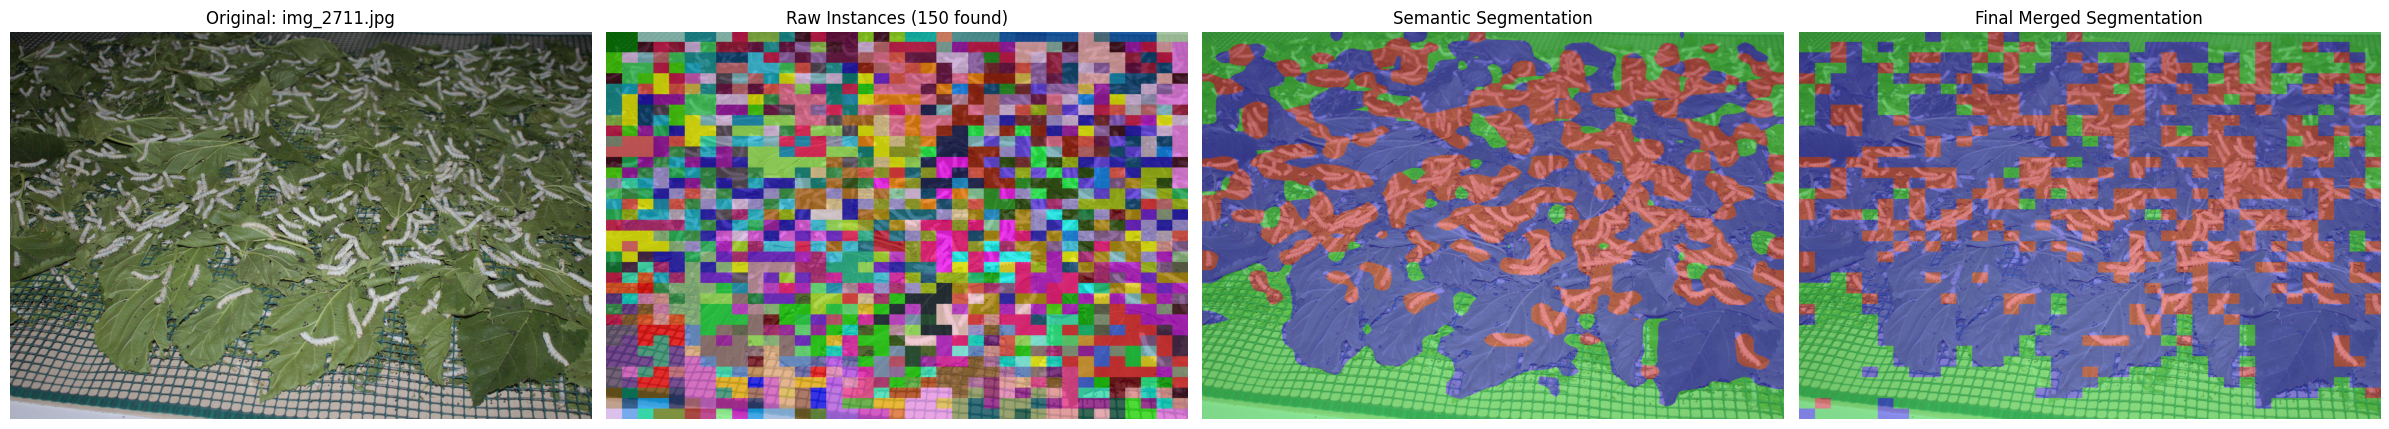


Processing image: silk_dataset\img_2849.jpg...
--- U2Seg Merged Results ---
Found 42 instances of 'background'
Found 55 instances of 'leaves'
Found 53 instances of 'silkworms'


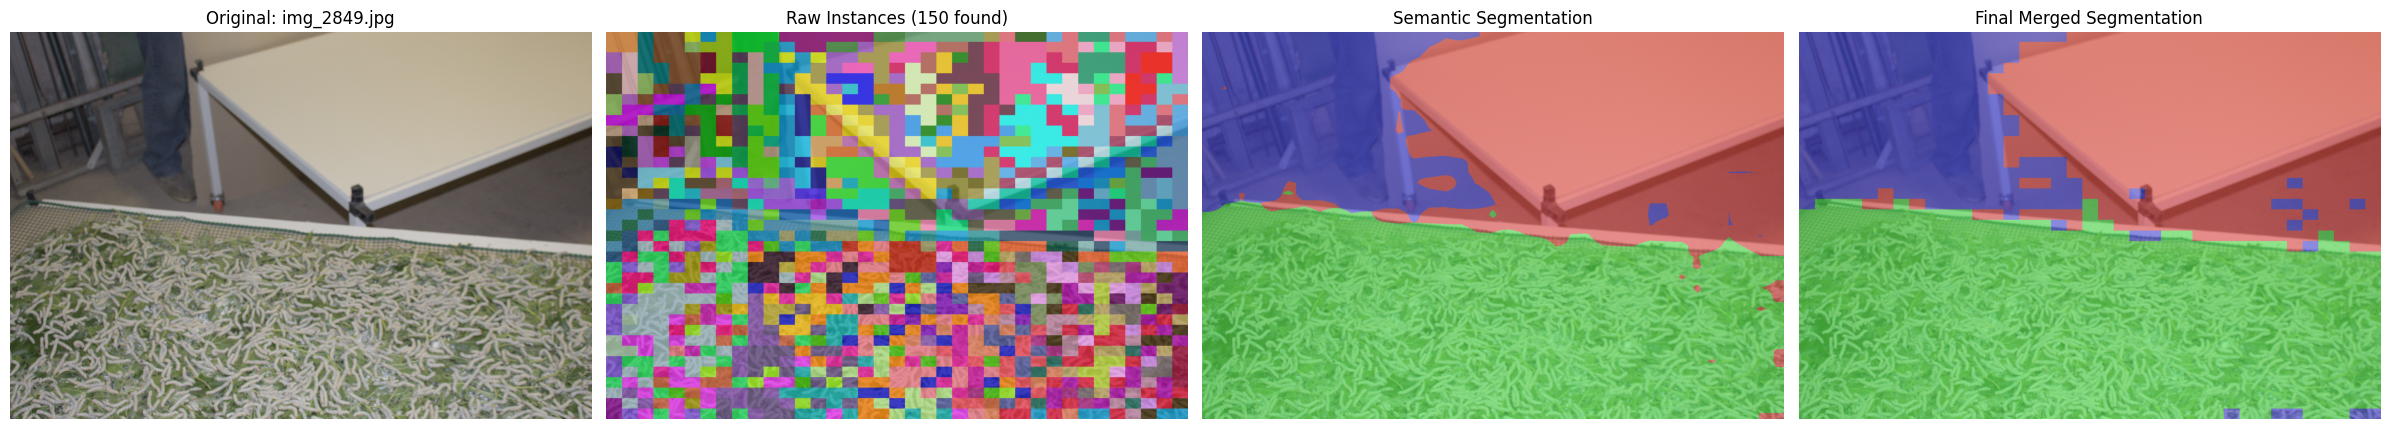


Processing image: silk_dataset\img_2868.jpg...
--- U2Seg Merged Results ---
Found 60 instances of 'background'
Found 70 instances of 'leaves'
Found 20 instances of 'silkworms'


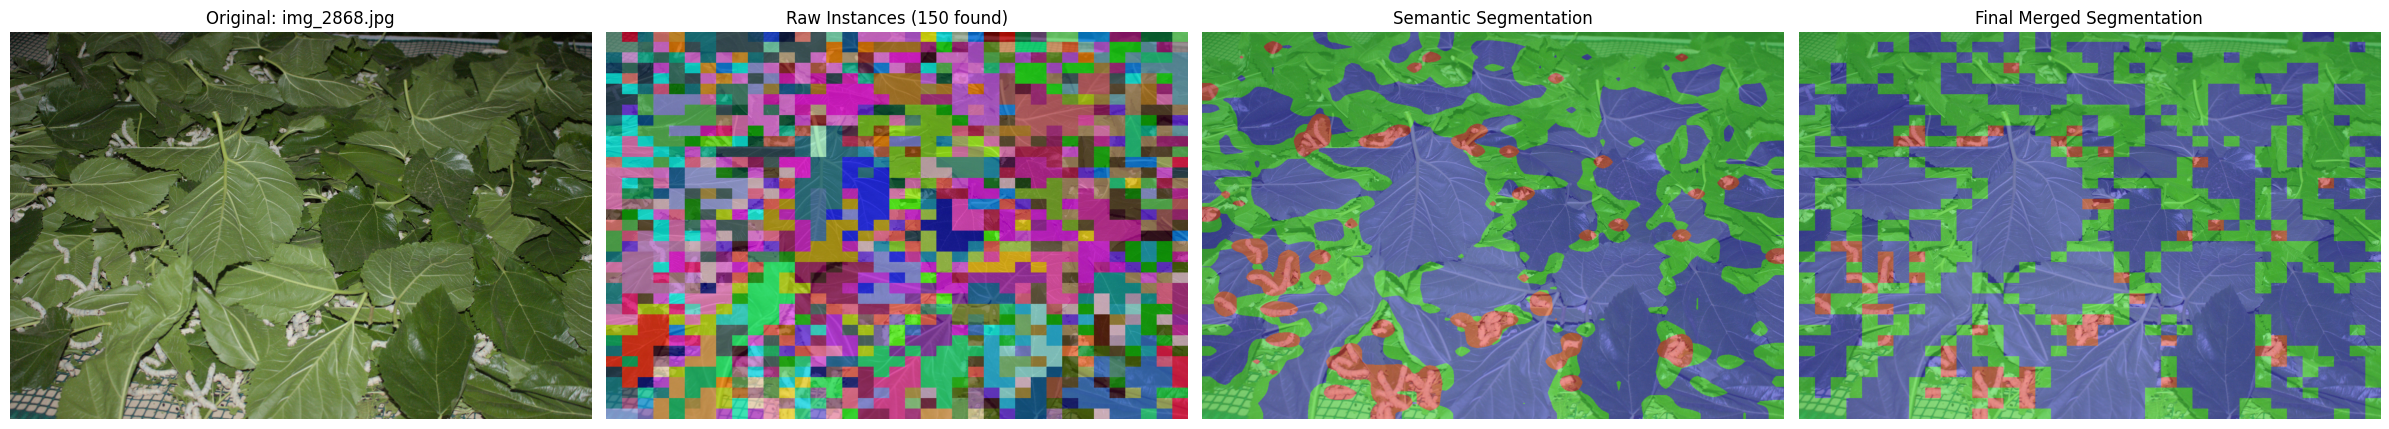


Processing image: silk_dataset\img_3009.jpg...
--- U2Seg Merged Results ---
Found 32 instances of 'background'
Found 71 instances of 'leaves'
Found 47 instances of 'silkworms'


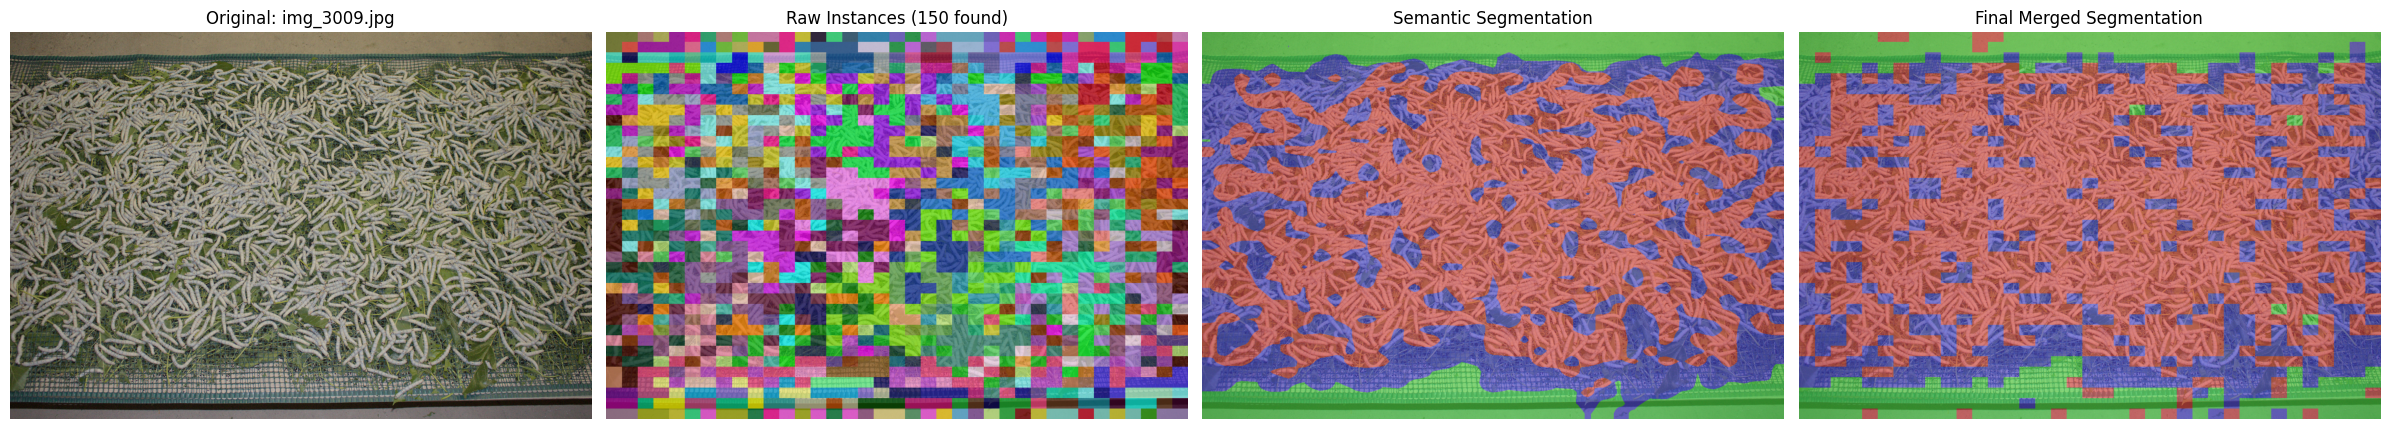


--- Evaluation Finished ---


In [7]:
# ===================================================================
# # 7. Evaluation
# Running the full pipeline on the specified test images.
# ===================================================================
print("\n--- Starting Evaluation ---")

# Instantiate segmentation models
instance_segmentor = UnsupervisedInstanceSegmentation(n_clusters=150, min_size=100)
semantic_segmentor = UnsupervisedSemanticSegmentation(n_classes=3)
u2seg_pipeline = U2SegUnified(feature_extractor, instance_segmentor, semantic_segmentor)

# Process each requested test image
for filename in TEST_IMAGE_FILENAMES:
    image_path = os.path.join(DATASET_FOLDER, filename)
    
    if not os.path.exists(image_path):
        print(f"\nWarning: Cannot find image '{filename}' in '{DATASET_FOLDER}'. Skipping.")
        continue
    
    print(f"\nProcessing image: {image_path}...")
    
    # Run the full segmentation and merge pipeline
    results = u2seg_pipeline.merge_and_segment(image_path)
    
    if results:
        # Print summary and display visualization
        print("--- U2Seg Merged Results ---")
        for name, count in results['category_counts'].items():
            print(f"Found {count} instances of '{name}'")
        plot_segmentation_visualization(image_path, results)
    else:
        print(f"Failed to process {image_path}.")

print("\n--- Evaluation Finished ---")